In [1]:
import numpy as np
import jax.numpy as jnp

import jax
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import rho_plus as rp

is_dark = False
theme, cs = rp.mpl_setup(is_dark)
rp.plotly_setup(is_dark)

In [2]:
from dataclasses import dataclass


@dataclass
class Bessel1DBasis:
    """Uses spherical Bessel functions with a cutoff, as in DimeNet++."""
    num_basis: int = 7
    cutoff: float = 7
    # Controls how fast the envelope goes to 0 at the cutoff.
    envelope_exp: int = 5

    def setup(self):
        def freq_init(rng):
            return jnp.arange(self.num_basis, dtype=jnp.float32) + 1
        self.freq = freq_init(None) 

    def __call__(self, x):
        dist = x[..., None] / self.cutoff
        env = 1

        # e(d) = sqrt(2/c) * sin(fπd/c)/d
        # we use sinc so it's defined at 0
        # jnp.sinc is sin(πx)/(πx)
        # e(d) = sqrt(2/c) * sin(πfd/c)/(fd/c) * f/c
        # e(d) = sqrt(2/c) * sinc(πfd/c)/(πfd/c) * πf/c

        e_d = jnp.sqrt(2 / self.cutoff) * jnp.sinc(self.freq * dist) * jnp.pi * self.freq / self.cutoff

        # debug_stat(dist=dist, env=env, freqs=freqs)
        return env * e_d
    
env = Bessel1DBasis(6)
env.setup()

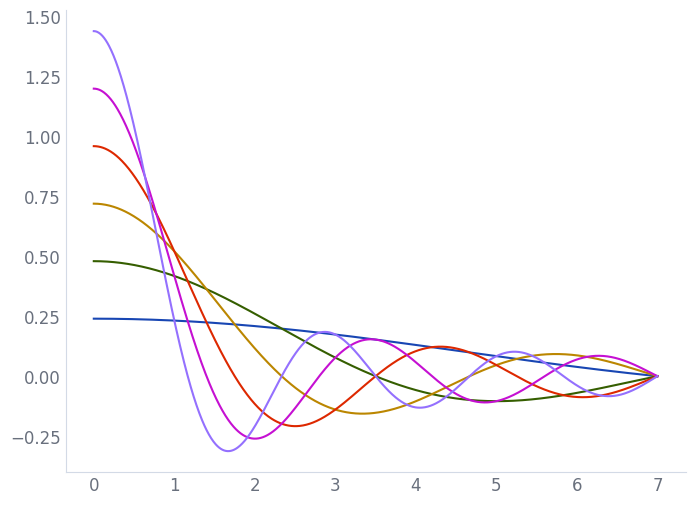

In [3]:
xx = jnp.linspace(0, env.cutoff, 1000)
plt.plot(xx, env(xx))

In [21]:
from eins import EinsOp, Reductions as R
from cdv.utils import debug_stat, debug_structure
nd = 8
index = slice(-1, 1, nd * 1j)

xyz = jnp.mgrid[index, index, index].reshape(3, -1).T

# https://www.wikiwand.com/en/List_of_common_coordinate_transformations#To_spherical_coordinates

def to_spherical(vecs):
    """vecs: [..., 3] -> (rho, azimuth, polar)"""    
    xx = vecs[..., 0]
    yy = vecs[..., 1]
    zz = vecs[..., 2]
    rho = R.l2_norm(vecs, axis=-1)
    azimuth = jnp.atan2(yy, xx) % (2 * jnp.pi)
    polar = jnp.atan2(jnp.hypot(xx, yy), zz)
    return rho, azimuth, polar

rho, azimuth, polar = to_spherical(xyz)
debug_stat(azimuth=azimuth / jnp.pi, polar=polar / jnp.pi, rho=rho);

azimuth
└──     (  0.0452    0.455    0.955     1.45     1.95)        1 ±    0.573

polar
└──     (  0.0635    0.304    0.468    0.685    0.937)      0.5 ±    0.211

rho
└──     (   0.247    0.845      1.1      1.3     1.73)     1.09 ±     0.31

In [24]:
from jax.scipy import special
from functools import partial

def _Y(m, l, vecs):
    rho, azimuth, polar = to_spherical(vecs)
    return special.sph_harm(jnp.atleast_1d(m), jnp.atleast_1d(l), azimuth, polar)

_Y(2, 2, xyz)

Array([-8.69802577e-08+0.25751615j, -8.69802577e-08+0.25751615j,
       -8.69802577e-08+0.25751615j, -8.69802577e-08+0.25751615j,
       -8.69802577e-08+0.25751615j, -8.69802577e-08+0.25751615j,
       -8.69802577e-08+0.25751615j, -8.69802577e-08+0.25751615j,
        8.35186988e-02+0.24359637j,  8.35186988e-02+0.24359637j,
        8.35186988e-02+0.24359637j,  8.35186988e-02+0.24359637j,
        8.35186988e-02+0.24359637j,  8.35186988e-02+0.24359637j,
        8.35186988e-02+0.24359637j,  8.35186988e-02+0.24359637j,
        1.77597329e-01+0.18647721j,  1.77597329e-01+0.18647721j,
        1.77597329e-01+0.18647721j,  1.77597329e-01+0.18647721j,
        1.77597329e-01+0.18647721j,  1.77597329e-01+0.18647721j,
        1.77597329e-01+0.18647721j,  1.77597329e-01+0.18647721j,
        2.47215495e-01+0.07210452j,  2.47215495e-01+0.07210452j,
        2.47215495e-01+0.07210452j,  2.47215495e-01+0.07210452j,
        2.47215495e-01+0.07210452j,  2.47215495e-01+0.07210452j,
        2.47215495e-01+0.

In [5]:
def generate_tuples_with_fixed_sum(length: int, sum: int):
    """Generates all non-negative integer tuples of a certain length with the specified sum."""
    if length == 1:
        yield (sum,)
        return

    if sum == 0:
        yield tuple(0 for _ in range(length))
        return

    for first in range(sum, -1, -1):
        for subtuple in generate_tuples_with_fixed_sum(length - 1, sum - first):
            yield (first,) + subtuple

from itertools import combinations

def gen_partitions(length: int, sum: int):
    for splits in combinations(range(sum + length - 1), r=length - 1):
        yield tuple(np.diff(splits, prepend=-1, append=sum + length - 1) - 1)

In [10]:
len(list(generate_tuples_with_fixed_sum(4, 0)))

1

In [11]:
s, l = 0, 4
set(generate_tuples_with_fixed_sum(s, l)) == set(gen_partitions(s, l))

: 

In [39]:
import math

math.comb(16, 4)

1820

In [2]:
from itertools import combinations

s = 0
l = 4

for splits in list(combinations(range(s + l - 1), l - 1)):
    print(np.diff(splits, prepend=-1, append=s + l - 1) - 1)

[0 0 0 0]
